# Machine Learning Models for SCOPE: Initial PCA Analysis
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils

logs = pd.read_csv("data/metis_logs.csv")
logs.head()

In [47]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
logs['is_alert'].describe()

count    9674.000000
mean        0.166425
std         0.372481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_alert, dtype: float64

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(AS_data.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_TS = utils.data_prep_pipeline(TS_data.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'])

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

In [ ]:
valid_AS['min_max'][valid_AS['min_max']['series'] == 'ABT US: WEB - LOWER FUNNEL - AUDIO - NON CHICAGO USERS']

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Quick PCA For Intuition of Possible Decision Boundaries

In [63]:
# PCA with 2 components, plot with colors for anomaly and not anomaly 
# to see what could be a good separation
from sklearn.decomposition import PCA

pca_AS = PCA(n_components=3)
pca_TS = PCA(n_components=3)
pca_RexT = PCA(n_components=3)

AS_PCA_data = valid_AS['min_max']
TS_PCA_data = valid_TS['min_max']
RexT_PCA_data = valid_RexT['min_max']

projected_AS = pca_AS.fit_transform(AS_PCA_data[[col for col in AS_PCA_data.columns 
                                                  if col not in ['series', 'run_date', 'is_alert']]])
projected_TS = pca_TS.fit_transform(TS_PCA_data[[col for col in TS_PCA_data.columns 
                                                  if col not in ['series', 'run_date', 'is_alert']
                                                     and 'site_type' not in col
                                                     and 'event_name' not in col]])
projected_RexT = pca_RexT.fit_transform(RexT_PCA_data[[col for col in RexT_PCA_data.columns 
                                                       if col not in ['run_date', 'is_alert',
                                                                      'isCountry', 'isSubregion', 
                                                                      'isRegion'] 
                                                           and 'series' not in col]])

In [64]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,5)

def pca_scatter(data, labels, color_map, point_size):
    plt.scatter(data[:, 0], data[:, 1],
                c=labels['is_alert'], edgecolor='none', alpha=1,
                cmap=plt.cm.get_cmap(color_map, 2), s=point_size)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar().set_ticks([0, 1])
    plt.show()

def pca_scatter_3d(data, labels, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], 
               c=labels['is_alert'], cmap=plt.cm.get_cmap(color_map, 2))
    ax.view_init(elev=50, azim=60)
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_zlabel('component 3')
    fig.colorbar(p).set_ticks([0, 1])
    plt.show()

#### AS PCA
We can see some overlap in the lower left corner and in the center, but there isn't an obvious separation for the AS data at all.

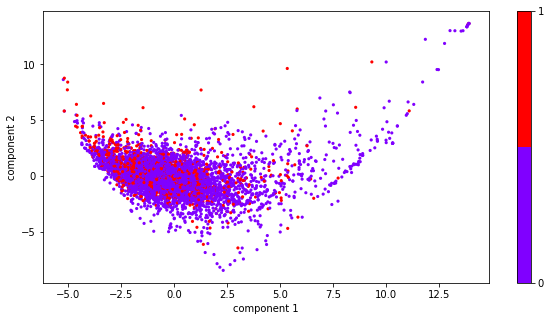

In [65]:
pca_scatter(projected_AS, AS_PCA_data, 'rainbow', 10)

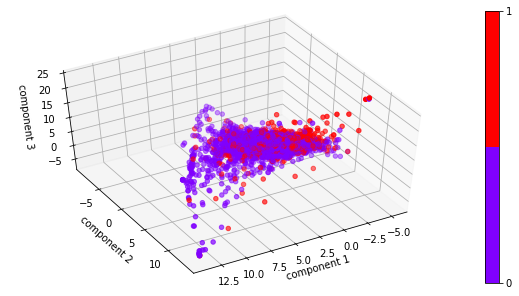

In [66]:
pca_scatter_3d(projected_AS, AS_PCA_data, 'rainbow')

#### TS PCA
We can better see the distinction here with the points in the middle (remember alert = 1), but it isn't obvious how we could draw a good boundary line.

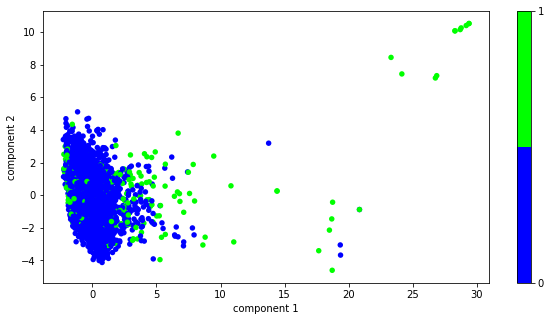

In [67]:
pca_scatter(projected_TS, TS_PCA_data, 'brg', 30)

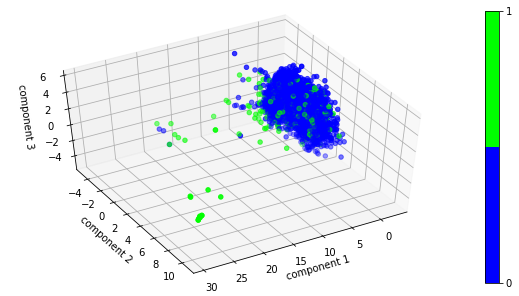

In [68]:
pca_scatter_3d(projected_TS, TS_PCA_data, 'brg')

#### RexT PCA
We see a little overlap in the bottom left corner, but they are literally right on top of each other, so we can't easily see how we could draw the boundary.

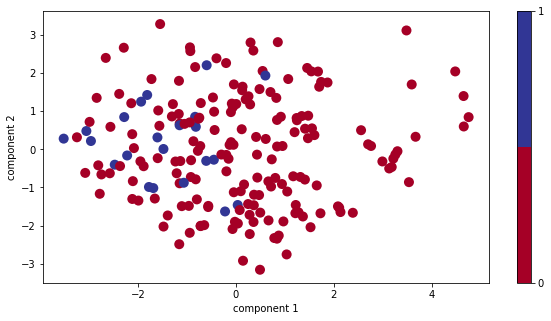

In [69]:
pca_scatter(projected_RexT, RexT_PCA_data, 'RdYlBu', 100)

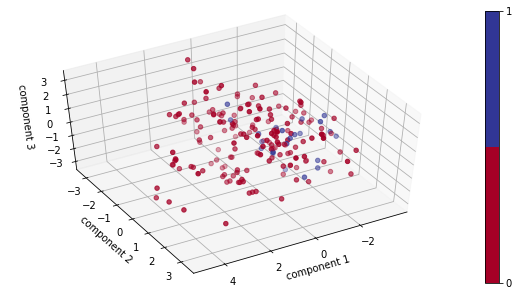

In [70]:
pca_scatter_3d(projected_RexT, RexT_PCA_data, 'RdYlBu')